In [4]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

Using TensorFlow backend.


1. Introduction. Explore first, train later:

 One intuitive way to improve the performance of our model is to simply improve the quality of input images. 

Reducing lighting-condition effects: as we will see, images come with many different lighting conditions, some images are very dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, there is a better approach. We can try the method of [Ben Graham]

Cropping uninformative area: everyone know this :) Here, I just find the codes from internet and choose the best .

In [5]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
#print(df_train)
print(df_train.head(10))
print(df_train.describe)
print(df_train.shape)
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)
print("x data after shuffling")
print(x)
print("y data after shuffling")
print(y)


        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
5  0083ee8054ee          4
6  0097f532ac9f          0
7  00a8624548a9          2
8  00b74780d31d          2
9  00cb6555d108          1
<bound method NDFrame.describe of            id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
3657  ffa47f6a7bf4          2
3658  ffc04fed30e6          0
3659  ffcf7b45f213          2
3660  ffd97f8cd5aa          0
3661  ffec9a18a3ce          2

[3662 rows x 2 columns]>
(3662, 2)
x data after shuffling
2462    aafe980edd0c
627     2c2aa057afc5
919     42a67337fa8e
2168    98e44127872f
814     3abac0961bfd
            ...     
1317    5b72ff04333d
2283    a07d9a5045cb
2004    8cb6b5b2f19c
607     2a8a9e957a6c
2775    bfda2fd0533a
Name: id_code, Leng

(3112,) (3112,) (550,) (550,)


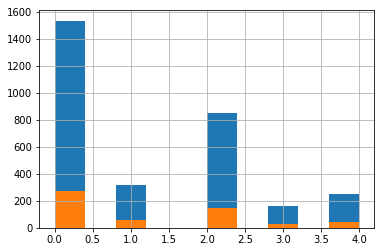

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

## 1.2 Original Inputs|

First, let have a glance of original inputs. Each row depicts each severity level. We can see two problems which make the severity difficult to spot on. First, some images are very dark [pic(0,2) and pic(4,4) ] and sometimes different color illumination is confusing [pic (3,3)]. Second, we can get the uninformative dark areas for some pictures [pic(0,1), pic(0,3)]. This is important when we reduce the picture size, as informative areas become too small. So it is intuitive to crop the uninformative areas out in the second case.

CPU times: user 3.52 s, sys: 312 ms, total: 3.83 s
Wall time: 3.65 s


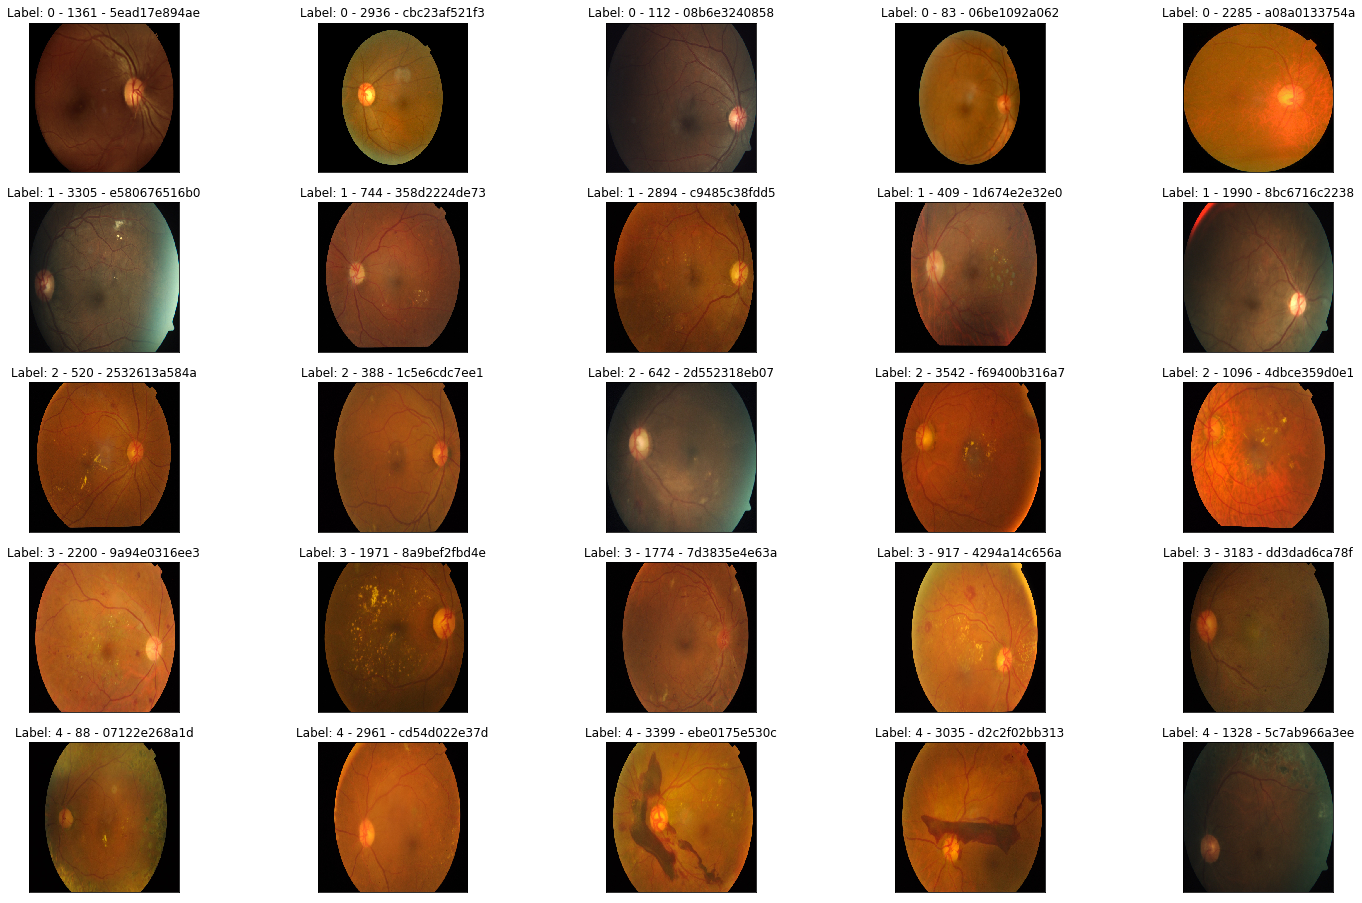

In [8]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d - %d - %s' % (class_id, idx, row['id_code']) )

We can try gray scale and feel understand better for some pictures, as color distraction is gone. For example, we can see more blood clearer in the upper part of pic(4,4), which has severity of level 4.

CPU times: user 3.05 s, sys: 224 ms, total: 3.27 s
Wall time: 3.07 s


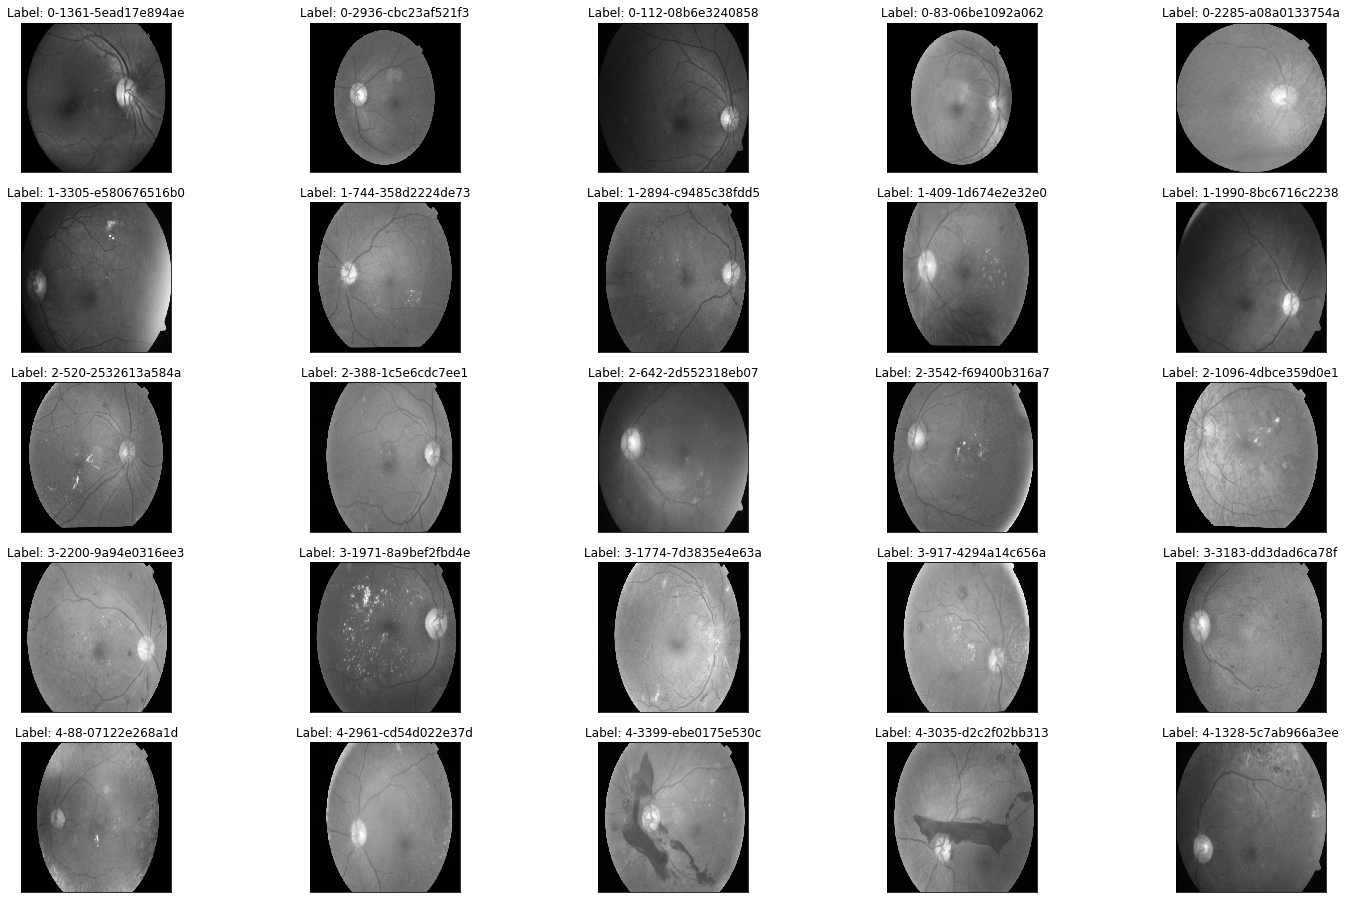

In [9]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
        

For severity level 4, I feel that two examples here are difficult to spot on, pic(4,1) and pic(4,4). As we try zooming to see the details (use real size image), we can see some abnormalities (*cotton wool spots* or *hard exudates* ?) in those eyes clearer (observe the lower-right part of the eye). Therefore, `IMG_SIZE` is definitely important for this problem. In the next section, we shall see better method than gray-scale conversion.

2136 3216


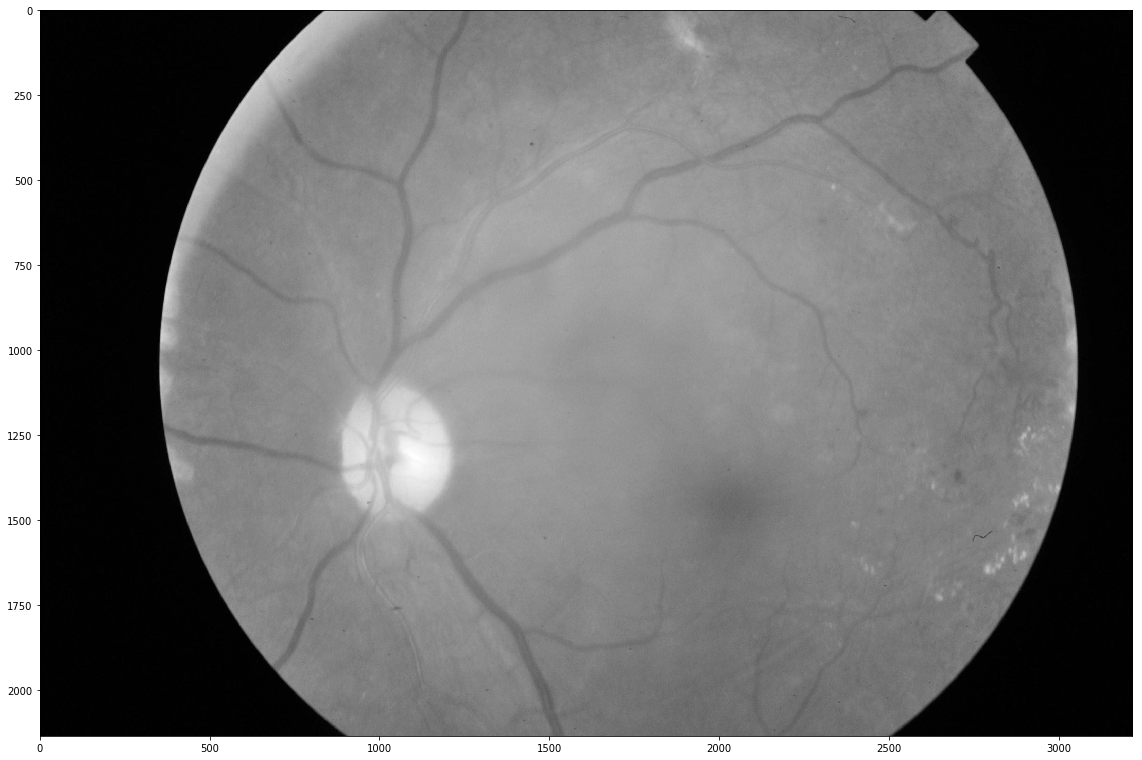

In [10]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, this still looks not so severe, can be class3
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape
print(height, width)

SCALE=2
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

# 2. Try Ben Graham's preprocessing method.

CPU times: user 20.8 s, sys: 156 ms, total: 21 s
Wall time: 8.13 s


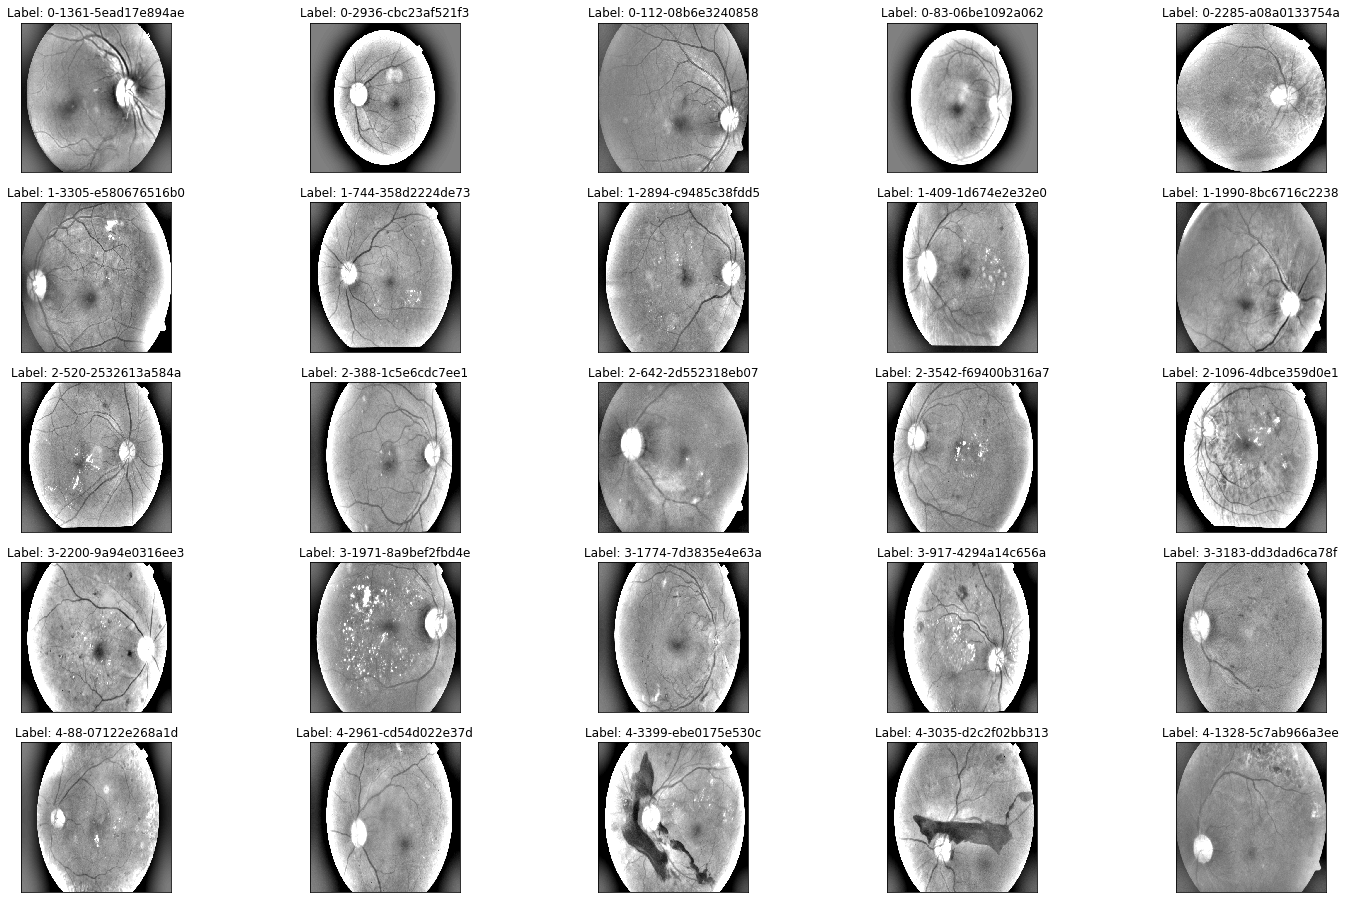

In [12]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [13]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


In [14]:
# OLD version of image color cropping, use crop_image_from_gray instead
# The above code work only for 1-channel. Here is my simple extension for 3-channels image
def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

'''all of these do not work'''

def crop_image2(image,threshold=5):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

def crop_image3(image):
    mask = image > 0

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return cropped

def crop_image4(image):
    _,thresh = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = image[y:y+h,x:x+w]
    return crop



In [15]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

CPU times: user 22.9 s, sys: 644 ms, total: 23.5 s
Wall time: 12.7 s


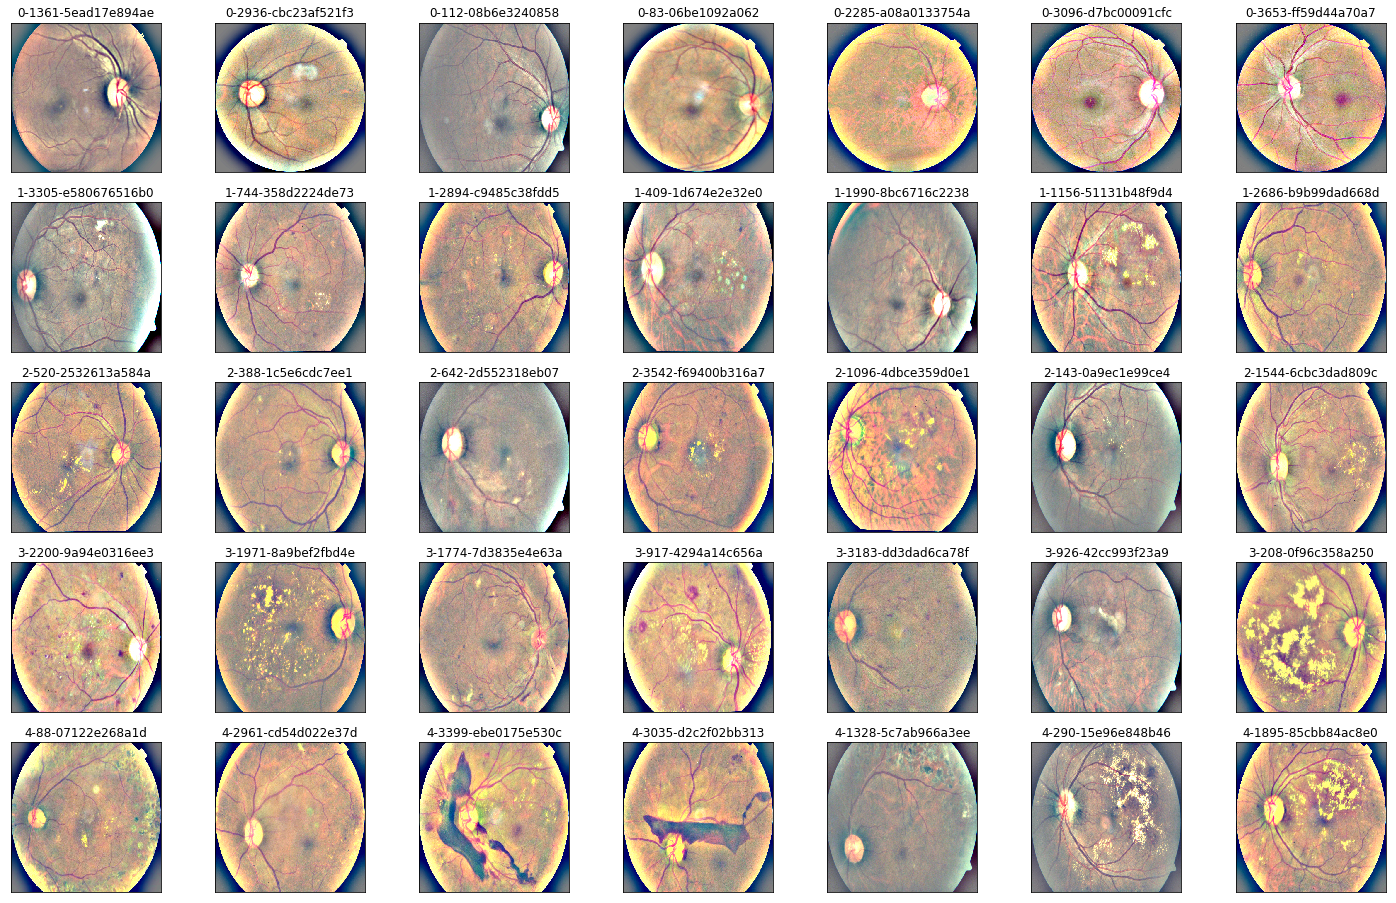

In [16]:
%%time

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

In [17]:
# ## try circle crop
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

CPU times: user 1min 28s, sys: 992 ms, total: 1min 29s
Wall time: 36.3 s


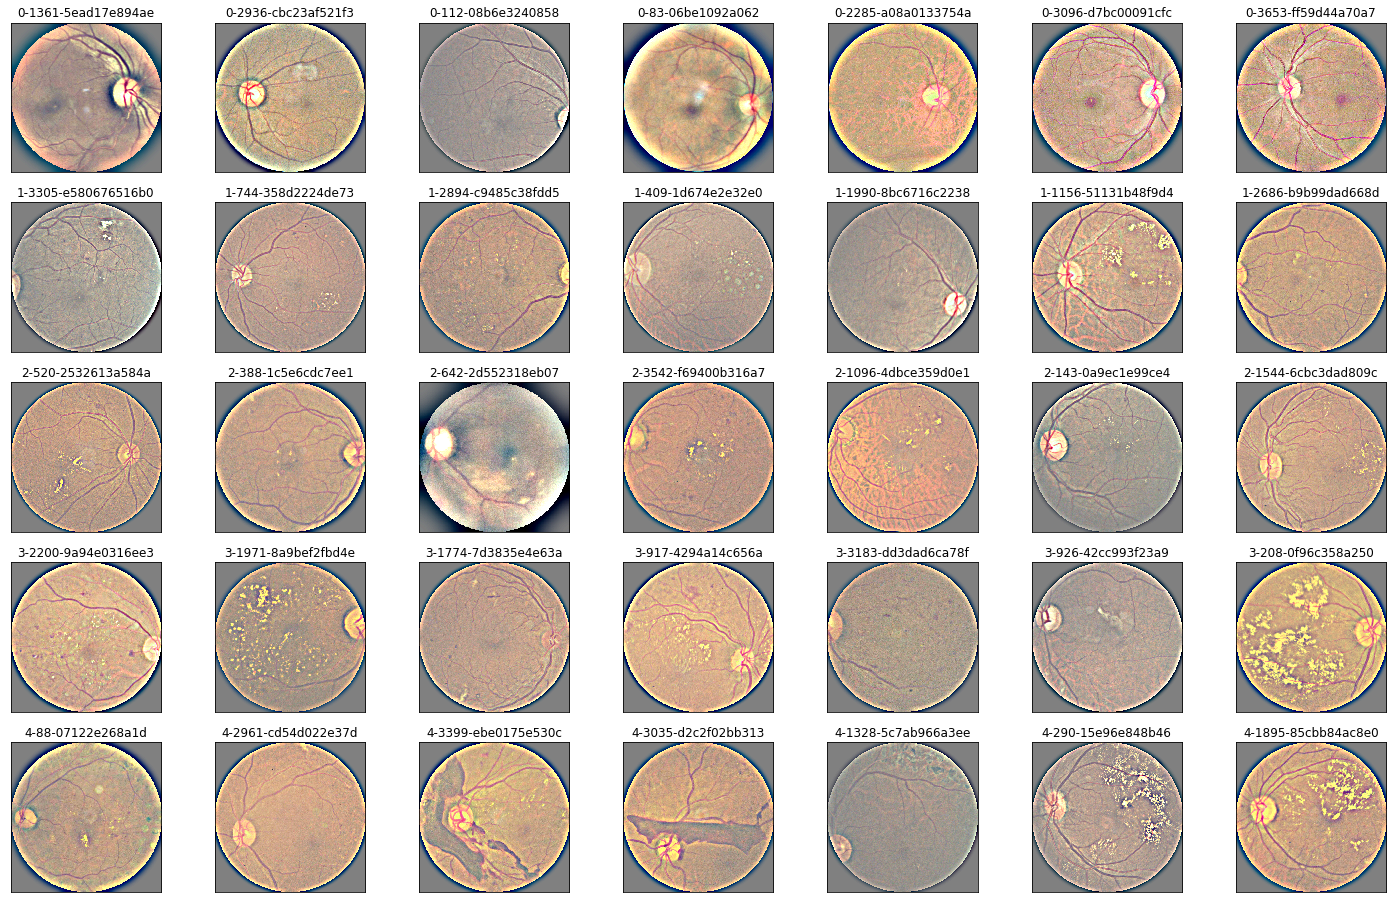

In [18]:
%%time
## try circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, can be class3
image = load_ben_color(path,sigmaX=10)

height, width = IMG_SIZE, IMG_SIZE
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')